# Milestone 4: Independent Project

## Author - Stacy Liu

## Abstract

### Problem
1. Which physiochemical features are most relevant in determining the quality of wine? And are they different for red and white?
2. And are the difference signficiant based on classical, bootstrap, and Bayesian method? 
3. Predict the quality scores of wine 

### Conclusion
1. From milestone 1, we found that quality of wine is more correlated (corr>0.2) with the following features: alcohol, density, volatile acidity, and chlorides. 
2. And from milestone 2, we found that the top 2 features (alcohol and density) are significantly different between red and white wines. 
3. PCA was used to narrow down model input features. 'pH' and'sulphates' were deemed not significant.
4. Quality scores of wine were then predicted using the following models
    - Multivariant linear regression: The RMSE is 1.39 (~20% of the target mean), meaning that the model can make general good prediction, but is not very accurate
    - Naive Bayes model: The RMSE is 1.02 which is better than the RMSE from the multivariant linear regression model. However the accuracy score is only 0.413
    - Gradient Boosting Classifier: The RMSE is 0.6375, about half that of the other two models. Since the LightGBM model gave us the lowest RMSE, this model should be used to make prediction of wine quality.

### About the data set

This dataset is from the University of California Irving Machine Learning Repository The data was compiled by Paulo Cortez from the following sources:

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

In [1]:
# Location of dataset
filename_red = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
filename_white = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

In [2]:
# Load necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import sklearn.naive_bayes as n_b
import statsmodels.api as sma
import lightgbm as lgb
from sklearn import preprocessing, metrics
import gc
import os

### Load the data set

In [3]:
red_wine=pd.read_csv(filename_red, delimiter=";", header=0)
white_wine=pd.read_csv(filename_white, delimiter=";", header=0)

# Milestone 1: Initial exploration of dataset

First, we'll take a look at the dimensions and data types of the column of the data frame

In [4]:
print(red_wine.shape)
print(red_wine.dtypes)
print(white_wine.shape)
print(white_wine.dtypes)

(1599, 12)
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object
(4898, 12)
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


Some key things to note about the red_wine and white_wine dataset:

- There are 1599 observations in the red wine data set and 4898 observations in the white wine data set
- Both have 12 variables with all of them being numeric

### Summary Statistics

In [5]:
red_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [6]:
white_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


The summary provides some useful information:

- White wines are rated on average about 0.2 points higher than red wines, but also have a higher standard deviation of 0.89 compared to red wine's std of 0.81
- There also appear to varying degrees of acidity, chlorides, sulfur dioxide, etc. between the two wines

I'll combine the two datasets in the next section to allow for easier manipulation

#### Concatenate red and white wine datasets

In [7]:
red_wine.insert(0,"type",'red', True)
white_wine.insert(0,"type",'white', True)
wine=pd.concat([red_wine, white_wine])

#### Examine the joint data

In [8]:
wine.head(10)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,red,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,red,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,red,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,red,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,red,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,red,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,red,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,red,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [9]:
# print summary statistics
print(wine.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

## Exploration and Visualization of Data

### Distribution of target variable : Quality

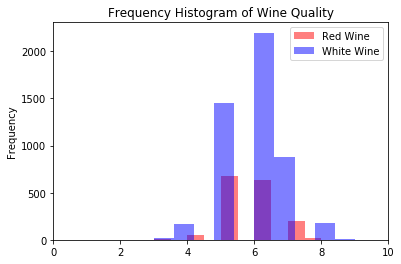

In [10]:
red=wine.loc[wine.type=='red', 'quality']
white=wine.loc[wine.type=='white', 'quality']

figure = dict(alpha=0.5, bins=10)

plt.hist(red, **figure, color='r', label='Red Wine')
plt.hist(white, **figure, color='b', label='White Wine')
plt.gca().set(title='Frequency Histogram of Wine Quality', ylabel='Frequency')
plt.xlim(0,10)
plt.legend()
plt.show()

The histogram shows that the quality scores of both red and white wines have a gaussian distribution.

- White wine has a higher center of around 6 compared to red with a center of around 5

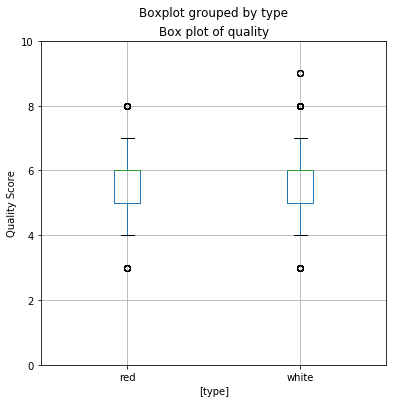

In [11]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca() # Define axis 
wine.loc[:,['quality', 'type']].boxplot(by = 'type', ax = ax)
ax.set_title('Box plot of quality')
ax.set_ylabel('Quality Score')
ax.set_ylim(0.0, 10.0) 
plt.show()

Red and white wines have the same IQR between 5 and 6 as well as similiar outlier observations at 3 and 8. However white, in addition to the outliers at 3 and 8, also has outlier observations at 9.

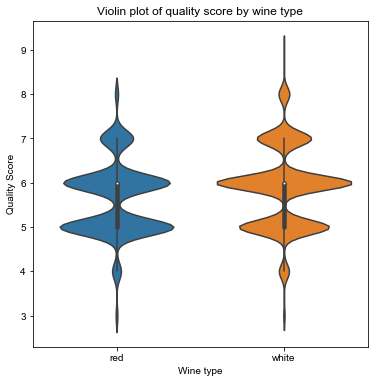

In [12]:
fig = plt.figure(figsize=(6,6)) # Define plot area
ax = fig.gca() # Define axis 
sns.set_style("whitegrid")
sns.violinplot(x = 'type', y = 'quality', data = wine, ax = ax)
ax.set_title('Violin plot of quality score by wine type') # Give the plot a main title
ax.set_xlabel('Wine type') # Set text for the x axis
ax.set_ylabel('Quality Score')# Set text for y axis
plt.show()

Similiar to the Histogram and box plot, the violin plot tells us that both wines are concentrated between 5 and 7 with white wine having the larger range and a longer upper tail.

### Covariance and correlation

In [13]:
#Pearson correlation for numeric variables
wine[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar'
      , 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density'
      , 'pH', 'sulphates', 'alcohol', 'quality']].cov()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.680740,0.046745,0.061122,-0.690720,0.013544,-6.506003,-24.112030,0.001784,-0.052675,0.057792,-0.147594,-0.086882
volatile acidity,0.046745,0.027105,-0.009043,-0.153537,0.002175,-1.030242,-3.856933,0.000134,0.006921,0.005536,-0.007391,-0.038200
citric acid,0.061122,-0.009043,0.021117,0.098490,0.000199,0.343372,1.603646,0.000042,-0.007706,0.001215,-0.001819,0.010854
residual sugar,-0.690720,-0.153537,0.098490,22.636696,-0.021492,34.021685,133.244854,0.007883,-0.204498,-0.131635,-2.039567,-0.153646
chlorides,0.013544,0.002175,0.000199,-0.021492,0.001227,-0.121284,-0.553714,0.000038,0.000252,0.002062,-0.010735,-0.006139
free sulfur dioxide,-6.506003,-1.030242,0.343372,34.021685,-0.121284,315.041192,723.261972,0.001369,-0.416249,-0.497756,-3.807165,0.859664
total sulfur dioxide,-24.112030,-3.856933,1.603646,133.244854,-0.553714,723.261972,3194.720039,0.005491,-2.166696,-2.319079,-17.914646,-2.042704
density,0.001784,0.000134,0.000042,0.007883,0.000038,0.001369,0.005491,0.000009,0.000006,0.000116,-0.002456,-0.000801
pH,-0.052675,0.006921,-0.007706,-0.204498,0.000252,-0.416249,-2.166696,0.000006,0.025853,0.004597,0.023252,0.002739
sulphates,0.057792,0.005536,0.001215,-0.131635,0.002062,-0.497756,-2.319079,0.000116,0.004597,0.022143,-0.000538,0.005001


In [14]:
# correlation matrix
wine_corr=wine[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar'
      , 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density'
      , 'pH', 'sulphates', 'alcohol', 'quality']].corr()
wine_corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743
volatile acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699
citric acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532
residual sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666
free sulfur dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463
total sulfur dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029,0.038485


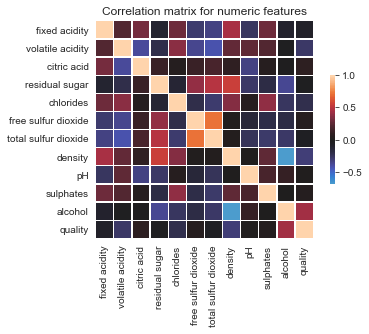

In [15]:
# correlation plot
sns.heatmap(wine_corr, vmax=1.0, center=0,
            square=True, linewidths=.25, cbar_kws={"shrink": 0.5})
plt.title('Correlation matrix for numeric features')
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.show()

From the correlation matrix and plot, it appears that quality is more correlated (corr>0.2) with the following variables (by desc order):

- alcohol
- density
- volatile acidity
- chlorides

#### Alcohol

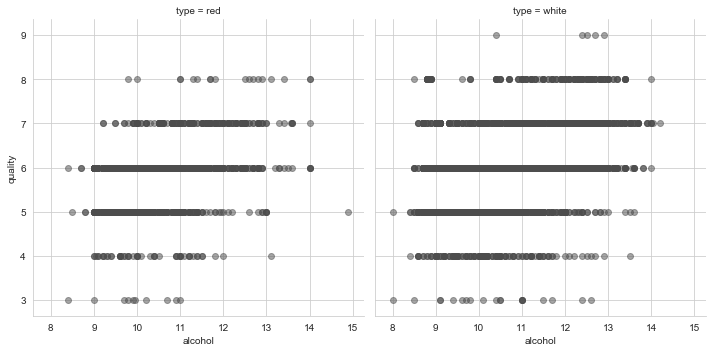

In [16]:
g = sns.FacetGrid(wine, 
                  col="type", 
                  margin_titles=True,
                 height=5,
                 aspect=1)
g = g.map(plt.scatter, "alcohol", "quality", alpha=0.5, color=".3") 

The alcohol scale of white wine appears to be a tad more spread out for most frequenct quality ratings (rating between 5-7). However in general for both wines, the alcohol scale has a wide range (between 9 to 13) for the most common 5-7 ratings.

For more outlier quality ratings, it appears that the lower end of quality correspond with lower alcohol content and the higher end of quality correspond with higher alcohol content.

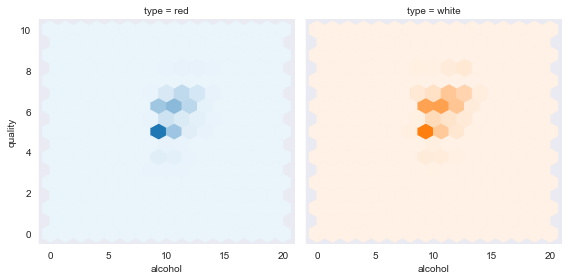

In [17]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(wine, hue="type", col="type", height=4)
g.map(hexbin, "alcohol", "quality", extent=[0, 20, 0, 10])

For both types of wine, the most common observation is alcohol content of 10 with quality of around 5.

#### Density

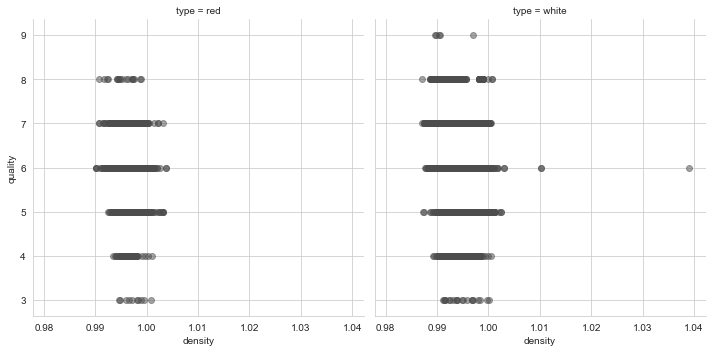

In [18]:
g = sns.FacetGrid(wine, 
                  col="type", 
                  margin_titles=True,
                 height=5,
                 aspect=1)
g = g.map(plt.scatter, "density", "quality", alpha=0.5, color=".3") 

For red wine, density appears to have a slight negative relationship with quality. Lower density red wine tend to have higher quality rating.

For white wine, there is no clear relationship between density and quality.

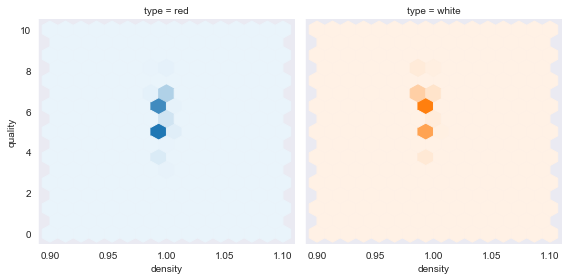

In [19]:
with sns.axes_style("dark"):
    g = sns.FacetGrid(wine, hue="type", col="type", height=4)
g.map(hexbin, "density", "quality", extent=[0.9, 1.1, 0, 10])

For the same density, it appears that white wines have higher quality ratings.

#### Volatile acidity

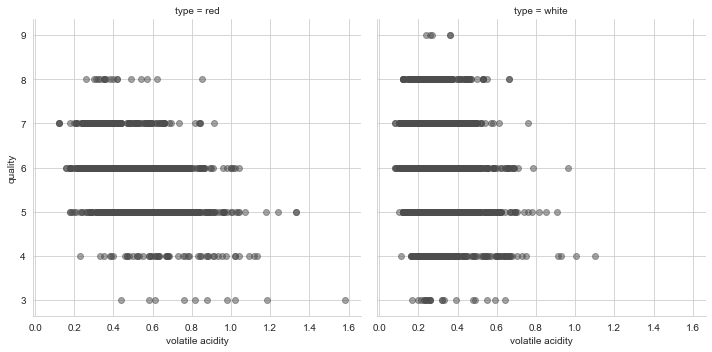

In [20]:
g = sns.FacetGrid(wine, 
                  col="type", 
                  margin_titles=True,
                 height=5,
                 aspect=1)
g = g.map(plt.scatter, "volatile acidity", "quality", alpha=0.5, color=".3") 

For red wine, volatile acidity appears to have a slight negative relationship with quality. Red wine with lower volatile acidity tend to have higher quality rating.

For white wine, there is no clear relationship between volatile acidity and quality. Althought most of the observations tend of have much lower volatile acidity of between 0.1 and 0.7 (red ranges between 0.2 and 1).

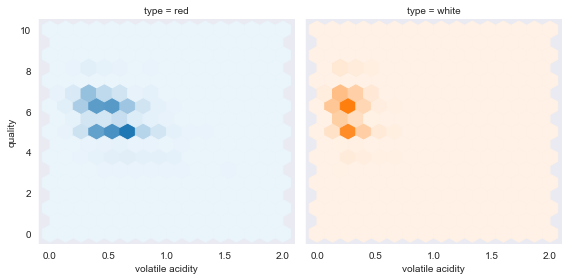

In [21]:
with sns.axes_style("dark"):
    g = sns.FacetGrid(wine, hue="type", col="type", height=4)
g.map(hexbin, "volatile acidity", "quality", extent=[0, 2, 0, 10])

Red wine appears to have more spread out volatile acidity compared to white.

#### Chlorides

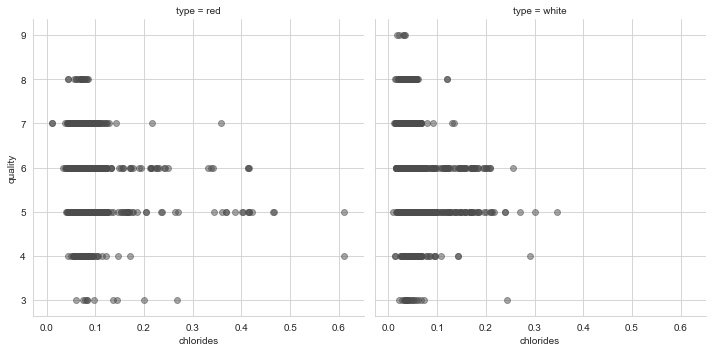

In [22]:
g = sns.FacetGrid(wine, 
                  col="type", 
                  margin_titles=True,
                 height=5,
                 aspect=1)
g = g.map(plt.scatter, "chlorides", "quality", alpha=0.5, color=".3") 

For both wines there is no clear relationship between chlorides and quality. Althought most of the observations tend of have much lower chloride of between 0.05 and 0.2.

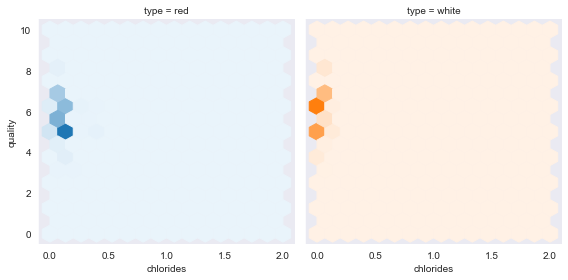

In [23]:
with sns.axes_style("dark"):
    g = sns.FacetGrid(wine, hue="type", col="type", height=4)
g.map(hexbin, "chlorides", "quality", extent=[0, 2, 0, 10])

For the same chloride level, white wine tend to be rated higher.

## EDA Summary

### Key Observations:
- From the summary statistics, white wines are rated on average about 0.2 points higher than red wines, but also have a higher standard deviation of 0.89 compared to red wine's std of 0.81
- From the box plot of quality, red and white wines have the same IQR between 5 and 6 as well as similiar outlier observations at 3 and 8. However white, in addition to the outliers at 3 and 8, also has outlier observations at 9. The violin plot gives us the same conclusion.
- From the correlation matrix and plot, it appears that quality is more correlated (corr>0.2) with the following variables (by desc order):
    - alcohol
    - density
    - volatile acidity
    - chlorides
- Alcohol: For both wines, it appears that the lower alcohol content corresponds with lower quality rating and higher alcohol content corresponds with higher quality rating
- Density: For red wine, density appears to have a slight negative relationship with quality. Lower density red wine tend to have higher quality rating. For white wine, there is no clear relationship between density and quality.
- Volatile Acidity:For red wine, volatile acidity appears to have a slight negative relationship with quality. Red wine with lower volatile acidity tend to have higher quality rating.For white wine, there is no clear relationship between volatile acidity and quality.
- Chlorides: For both wines there is no clear relationship between chlorides and quality. Althought most of the observations tend of have much lower chloride of between 0.05 and 0.2.

# Milestone 2 - Feature Significance

From milestone 1, we found that quality of wine is more correlated (corr>0.2) with the following features: alcohol, density, volatile acidity, and chlorides. Continuing down that path with this milestone, I'll perform the following to understand if the difference between red and white wine is significant for the top 2 features (alcohol and density):

- Identify a likely distribution for those features
- Compute basic summary statistics by classical, bootstrap, and Bayesian methods
- Compute CI by classical, bootstrap, and Bayesian
- Perform hypothesis Test to determine if the differences in alcohol and density between red and white wines are significant

### Distribution of target variable: Quality

<function matplotlib.pyplot.show(*args, **kw)>

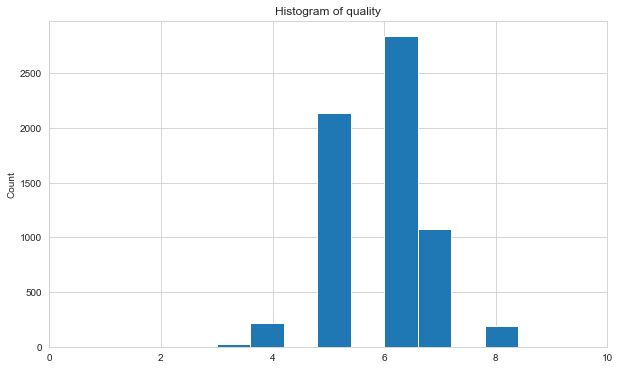

In [24]:
fig = plt.figure(figsize=(10, 6)) # Define plot area
ax = fig.gca() # Define axis 
wine.loc[:,'quality'].plot.hist(bins=10)
ax.set_title('Histogram of quality') # Give the plot a main title
ax.set_ylabel('Count')# Set text for y axis
ax.set_xlim(0.0, 10.0) # Set the limits of the y axis
plt.show

Quality appears to be have a gaussian distribution centered around 6.

### Distribution of Alcohol

<function matplotlib.pyplot.show(*args, **kw)>

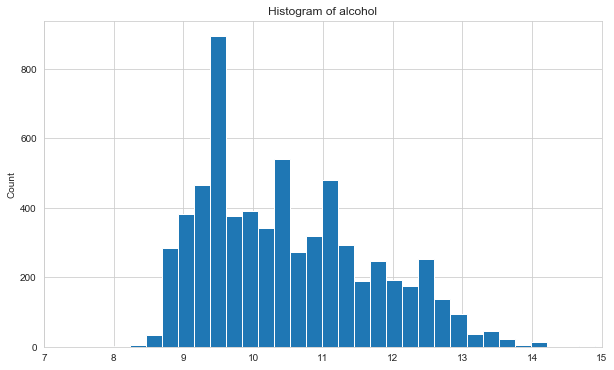

In [25]:
fig = plt.figure(figsize=(10, 6)) # Define plot area
ax = fig.gca() # Define axis 
wine.loc[:,'alcohol'].plot.hist(bins=30)
ax.set_title('Histogram of alcohol') # Give the plot a main title
ax.set_ylabel('Count')# Set text for y axis
ax.set_xlim(7, 15.0) # Set the limits of the y axis
plt.show

Test if alcohol has a log distribution

<function matplotlib.pyplot.show(*args, **kw)>

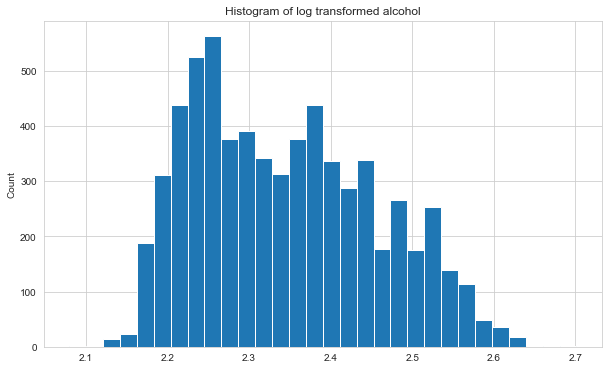

In [26]:
# Add column for log alcohol
wine['log_alcohol']=np.log(wine['alcohol'])

fig = plt.figure(figsize=(10, 6)) # Define plot area
ax = fig.gca() # Define axis 
wine.loc[:,'log_alcohol'].plot.hist(bins=30)
ax.set_title('Histogram of log transformed alcohol') # Give the plot a main title
ax.set_ylabel('Count')# Set text for y axis
plt.show

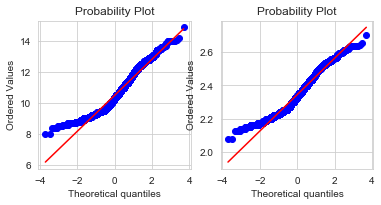

In [27]:
# Q-Q plots of alcohol and log alcohol
def qq_plot(vec1, vec2):
    plt.figure(figsize=(6, 6)).gca() # define axis
    ax1 = plt.subplot(221) ## setup the left subplot
    ss.probplot(vec1, plot = ax1) ## Plot the left subplot
    ax1 = plt.subplot(222) ## Set up the right subplot
    ss.probplot(vec2, plot = ax1) ## Plot the right subplot
qq_plot(wine['alcohol'], wine['log_alcohol'])  

The Q_Q plot shows the quantiles of a standard normal distribution on the horizontal axis and the quantiles of the alcohol (or log alcohol for the second plot) on the vertical axis. If the sample is normal the data points will fall in a straight line.

In this case, it appears that both are similiarly distributed (both right skewed). Since log transforming alcohol did not improve the distribution much, I'll be using alcohol for the next steps.

### Distribution of Density

<function matplotlib.pyplot.show(*args, **kw)>

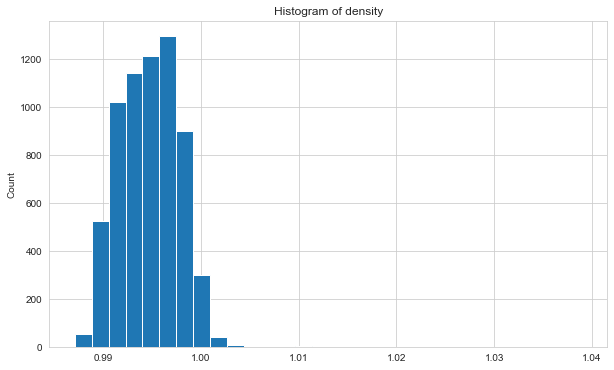

In [28]:
fig = plt.figure(figsize=(10, 6)) # Define plot area
ax = fig.gca() # Define axis 
wine.loc[:,'density'].plot.hist(bins=30)
ax.set_title('Histogram of density') # Give the plot a main title
ax.set_ylabel('Count')# Set text for y axis
plt.show

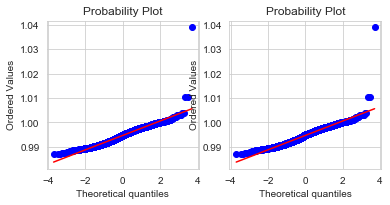

In [29]:
qq_plot(wine['density'], wine['density']) 

Density appears to have a normal distribution, except for 2 outlier observations. I'll be using density as it is for the next steps.

## Basic Summary Statistics

### Alcohol  - using classical method

In [30]:
alc_means = np.array([
        np.random.choice(wine['alcohol'], size=50, replace=True).mean()
        for i in range(500)])

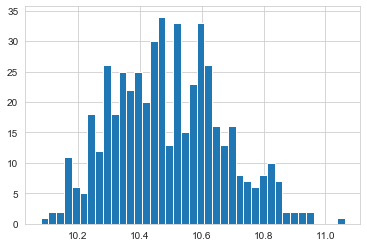

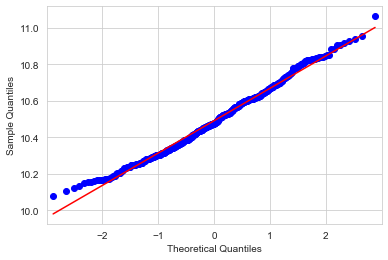

In [31]:
breaks = np.linspace(alc_means.min(), alc_means.max(), num=40)
plt.hist(alc_means, bins=breaks)
plt.show()
sma.qqplot(alc_means, line='s')
plt.show()

In [32]:
size = 50
alc_pop_mean = alc_means.mean()
alc_pop_std = alc_means.std()
print('Alcohol estimated mean (%.3f) vs actual mean (%.3f)' % (alc_pop_mean, wine['alcohol'].mean()))
print('Alcohol estimated s.d. (%.3f) vs actual s.d./sqrt(size) (%.3f)' % (alc_pop_std, wine['alcohol'].std()/np.sqrt(size)))

Alcohol estimated mean (10.491) vs actual mean (10.492)
Alcohol estimated s.d. (0.177) vs actual s.d./sqrt(size) (0.169)


### Alcohol - using bootstrap method

In [33]:
n=1000

alcohol_bootstrap_means=pd.Series([wine.sample(frac=1, replace=True).alcohol.mean()
                                for i in range(n)])
print(alcohol_bootstrap_means.describe())

count    1000.000000
mean       10.491349
std         0.015307
min        10.440330
25%        10.481560
50%        10.491399
75%        10.501607
max        10.535889
dtype: float64


### Alcohol - using Bayesian

In [34]:
def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity

In [35]:
num_samples=25
sample = wine.sample(n=num_samples)
mean_alcohol = sample['alcohol'].mean()
print('Mean of alcohol: %.2f' % mean_alcohol)

Mean of alcohol: 10.47


Mean = 10.468, Standard deviation = 1.111


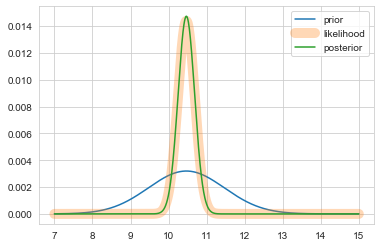

In [36]:
N = 1000
p_alcohol = np.linspace(7, 15, num=N)


pp_alcohol = ss.norm.pdf(p_alcohol, loc=sample['alcohol'].mean())
pp_alcohol = pp_alcohol / pp_alcohol.sum()

def comp_like(p, x): 
    variance = np.std(x)**2 # sigmasqr
    x_mean = np.asarray(x).mean()  # xbar
    print('Mean = %.3f, Standard deviation = %.3f' % (x_mean, np.std(x)))
    n = len(x)
    l = np.exp(-n * np.square(x_mean - p) / (2 * variance))
    return l / l.sum()

like_alcohol = comp_like(p_alcohol, sample['alcohol'])
post_alcohol = posterior(pp_alcohol, like_alcohol)

plt.plot(p_alcohol, pp_alcohol, label='prior')
plt.plot(p_alcohol, like_alcohol, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p_alcohol, post_alcohol, label='posterior')
plt.legend()
plt.show()

#### Alcohol Summary Statistics:
- Classical: mean of 10.48 with std of 0.163
- Bootstrap: mean of 10.49 with std of 0.014
- Bayesian: mean of 10.228 with std of 1.119

### Density - using classical method

In [37]:
den_means = np.array([
        np.random.choice(wine['density'], size=50, replace=True).mean()
        for i in range(500)])

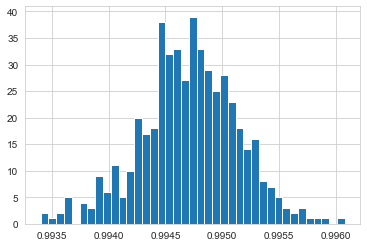

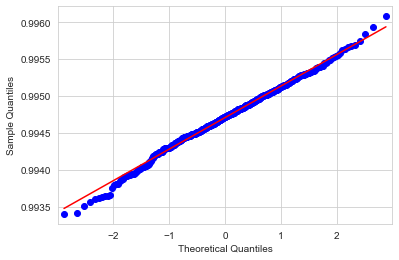

In [38]:
breaks = np.linspace(den_means.min(), den_means.max(), num=40)
plt.hist(den_means, bins=breaks)
plt.show()
sma.qqplot(den_means, line='s')
plt.show()

In [39]:
size = 50
den_pop_mean = den_means.mean()
den_pop_std = den_means.std()
print('Density estimated mean (%.4f) vs actual mean (%.4f)' % (den_pop_mean, wine['density'].mean()))
print('Density estimated s.d. (%.6f) vs actual s.d./sqrt(size) (%.6f)' % (den_pop_std, wine['density'].std()/np.sqrt(size)))

Density estimated mean (0.9947) vs actual mean (0.9947)
Density estimated s.d. (0.000428) vs actual s.d./sqrt(size) (0.000424)


### Density - using bootstrap method

In [40]:
n=1000

density_bootstrap_means=pd.Series([wine.sample(frac=1, replace=True).density.mean()
                                for i in range(n)])
print(density_bootstrap_means.describe())

count    1000.000000
mean        0.994697
std         0.000038
min         0.994569
25%         0.994671
50%         0.994697
75%         0.994723
max         0.994815
dtype: float64


### Density - using Bayesian

In [41]:
mean_density = sample['density'].mean()
print('Mean of density: %.2f' % mean_density)

Mean of density: 0.99


Mean = 0.995, Standard deviation = 0.003


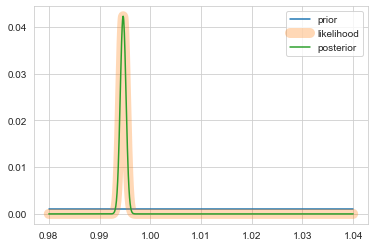

In [42]:
N = 1000
p_density = np.linspace(0.98, 1.04, num=N)


pp_density = ss.norm.pdf(p_density, loc=sample['density'].mean())
pp_density = pp_density / pp_density.sum()

like_density = comp_like(p_density, sample['density'])
post_density = posterior(pp_density, like_density)

plt.plot(p_density, pp_density, label='prior')
plt.plot(p_density, like_density, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p_density, post_density, label='posterior')
plt.legend()
plt.show()

#### Density Summary Statistics:
- Classical: mean of 0.9947 with std of 0.000426
- Bootstrap: mean of 0.9947 with std of 0.000037
- Bayesian: mean of 0.995 with std of 0.003

### Alcohol Confidence Interval - using classical method

In [43]:
alpha = 0.95
half_width = ss.norm.ppf((1 + alpha)/2, loc=alc_pop_mean, scale=alc_pop_std) - alc_pop_mean
print('The half width is %.2f' % half_width)

alc_ci_low = alc_pop_mean - half_width
alc_ci_high = alc_pop_mean + half_width

print('The actual alcohol mean is %.2f' % wine['alcohol'].mean())
print('The %.2f level CI for alcohol is (%.2f , %.2f)' % (alpha, alc_ci_low, alc_ci_high))

The half width is 0.35
The actual alcohol mean is 10.49
The 0.95 level CI for alcohol is (10.14 , 10.84)


### Alcohol Confidence Interval - using bootstrap method

In [44]:
def confidence_interval (a, p=5):
    #95% confidence interval
    lower_CI=np.percentile(a, p/2.)
    higher_CI=np.percentile(a, 100-p/2.)
    print('95% bootstrapped confidence interval is ' + str(lower_CI) + " to "+ str(higher_CI))

In [45]:
confidence_interval(alcohol_bootstrap_means)

95% bootstrapped confidence interval is 10.45897553999286 to 10.520734595454321


### Alcohol Confidence Interval - using bayesian

In [46]:
def confidence_interval_bayes (p, post, num_samples, lower_q, upper_q):
    samples = np.random.choice(p, size=num_samples, replace=True, p=post)
    ci = np.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    interval = upper_q-lower_q
    print('The %.3f bayes credible interval is %.4f to %.4f' 
          % (interval, ci[0], ci[1]))

In [47]:
confidence_interval_bayes(p_alcohol, post_alcohol, num_samples=100000, lower_q=0.025, upper_q=0.975)

The 0.950 bayes credible interval is 10.0430 to 10.8919


### Alcohol Confidence Interval Summary:
- Classical: The 0.95 level CI for alcohol is (10.17 , 10.82)
- Bootstrap: The 95% bootstrapped confidence interval is 10.46 to 10.52
- Bayesian: The 0.95 bayes credible interval is 9.80 to 10.66

### Density Confidence Interval - using classical method

In [48]:
alpha = 0.95
half_width = ss.norm.ppf((1 + alpha)/2, loc=den_pop_mean, scale=den_pop_std) - den_pop_mean
print('The half width is %.4f' % half_width)

den_ci_low = den_pop_mean - half_width
den_ci_high = den_pop_mean + half_width

print('The actual density mean is %.4f' % wine['density'].mean())
print('The %.2f level CI for density is (%.4f , %.4f)' % (alpha, den_ci_low, den_ci_high))

The half width is 0.0008
The actual density mean is 0.9947
The 0.95 level CI for density is (0.9939 , 0.9955)


### Density Confidence Interval - using bootstrap method

In [49]:
confidence_interval(density_bootstrap_means)

95% bootstrapped confidence interval is 0.994625508619356 to 0.9947712801100462


### Density Confidence Interval - using Bayesian

In [50]:
confidence_interval_bayes(p_density, post_density, num_samples=100000, lower_q=0.025, upper_q=0.975)

The 0.950 bayes credible interval is 0.9935 to 0.9957


### Density Confidence Interval Summary:
- Classical: The 0.95 level CI for density is (0.9938 , 0.9955)
- Bootstrap: The 95% bootstrapped confidence interval is 0.9946 to 0.9948
- Bayesian: The 0.95 bayes credible interval is 0.9938 to 0.9963

## Hypothesis Test to determine if the differences in alcohol and density between red and white wines are significant

### Alcohol - T-test

In [51]:
def t_test(a, b, alpha, alternative='two-sided'):
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b, equal_var=False)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   

In [52]:
alcohol_test = t_test(wine.loc[wine.type=='red', 'alcohol'], wine.loc[wine.type=='white', 'alcohol'], 0.05)
alcohol_test

DegFreedom    3100.474621
Difference      -0.091284
Statistic       -2.859029
PValue           0.004278
Low95CI         -0.153887
High95CI        -0.028681
dtype: float64

- The t-statistic is big and the p-value is small. Therefore, there is a low chance that the difference in means is from random variation alone.
- The 95% confidence interval does not straddle 0.

**Based on these statistics we can reject the null hypothesis. The mean alcohol content of red and white wines are significantly different.**

### Alcohol - Bootstrap test

In [53]:
def plot_hist(x, p=5, bins=10):
    # Plot the distribution and mark the mean
    plt.hist(x, alpha=.5, bins=bins)
    plt.axvline(x.mean())
    # 95% confidence interval    
    plt.axvline(np.percentile(x, p/2.), color='red', linewidth=3)
    plt.axvline(np.percentile(x, 100-p/2.), color='red', linewidth=3)

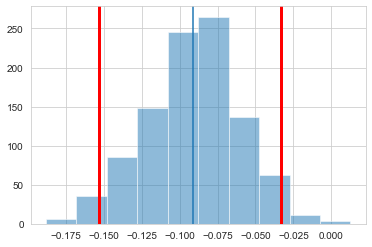

In [54]:
n_replicas = 1000

diffs = []
for i in range(n_replicas):
    sample = wine.sample(frac=1.0, replace=True)
    red_sample_mean = sample[sample['type'] == 'red'].alcohol.mean()
    white_sample_mean = sample[sample['type'] == 'white'].alcohol.mean()
    diffs.append(red_sample_mean - white_sample_mean)
diffs = pd.Series(diffs)

plot_hist(diffs)

The 95% confidence interval does not include zero. Therefore, similiar to the conclusion from t-test, we can state that the mean alcohol content of red and white wines are significantly different.

### Density - T-test

In [55]:
density_test = t_test(wine.loc[wine.type=='red', 'density'], wine.loc[wine.type=='white', 'density'], 0.05)
density_test

DegFreedom    4340.357457
Difference       0.002719
Statistic       42.708511
PValue           0.000000
Low95CI          0.002594
High95CI         0.002844
dtype: float64

- The t-statistic is big and the p-value is small. Therefore, there is a low chance that the difference in means is from random variation alone
- The 95% confidence interval does not straddle 0.

**Based on these statistics we can reject the null hypothesis. The mean density of red and white wines are significantly different.**

### Density - Bootstrap test

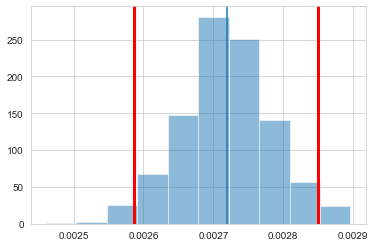

In [56]:
diffs = []
for i in range(n_replicas):
    sample = wine.sample(frac=1.0, replace=True)
    red_sample_mean = sample[sample['type'] == 'red'].density.mean()
    white_sample_mean = sample[sample['type'] == 'white'].density.mean()
    diffs.append(red_sample_mean - white_sample_mean)
diffs = pd.Series(diffs)

plot_hist(diffs)

The 95% confidence interval does not include zero. Therefore, similiar to the conclusion from t-test, we can state that the mean density of red and white wines are significantly different.

## Feature Significance Summary

1. Identify a likely distribution for those features
    - Alcohol: Right skewed normal distribution 
    - Density: Normal distribution
2. Compute basic summary statistics by classical, bootstrap, and Bayesian methods
    - Alcohol:
        - Classical: mean of 10.48 with std of 0.163
        - Bootstrap: mean of 10.49 with std of 0.014
        - Bayesian: mean of 10.228 with std of 1.119
    - Density: 
        - Classical: mean of 0.9947 with std of 0.000426
        - Bootstrap: mean of 0.9947 with std of 0.000037
        - Bayesian: mean of 0.995 with std of 0.003
3. Compute CI by classical, bootstrap, and Bayesian
    - Alcohol:
        - Classical: The 0.95 level CI for alcohol is (10.17 , 10.82)
        - Bootstrap: The 95% bootstrapped confidence interval is 10.46 to 10.52
        - Bayesian: The 0.95 bayes credible interval is 9.80 to 10.66
    - Density:
        - Classical: The 0.95 level CI for density is (0.9938 , 0.9955)
        - Bootstrap: The 95% bootstrapped confidence interval is 0.9946 to 0.9948
        - Bayesian: The 0.95 bayes credible interval is 0.9938 to 0.9963
4. Perform hypothesis Test to determine if the differences in alcohol and density between red and white wines are significant
    - Alcohol: Both t-test and bootstrap determined that the mean alcohol content of red and white wines are significantly different
    - Density: Both t-test and bootstrap determined that the mean density of red and white wines are significantly different

# Milestone 3 - Linear Regression Model

From milestone 1, we found that quality of wine is more correlated (corr>0.2) with the following features: alcohol, density, volatile acidity, and chlorides. And from milestone 2, we found that the top 2 features (alcohol and density) are significantly different between red and white wines.

In this milestone, I'll prepare the data via cleaning and normalizing before using a linear regression model to predict the quality scores of wines.

#### Data Preprocessing

In [57]:
#label encoding wine type
le = LabelEncoder() 
  
wine['type']= le.fit_transform(wine['type']) 

In [58]:
features = ['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
           'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
           'pH', 'sulphates', 'alcohol']
target = 'quality'

#split into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(wine[features], wine[target], test_size =0.20)

In [59]:
y_train

1217    6
1050    5
2443    5
574     7
3372    6
       ..
1314    6
2502    4
1912    6
3700    5
14      5
Name: quality, Length: 5197, dtype: int64

In [60]:
#perform standardization before appling PCA
scaler = StandardScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
print(X_test[:5])
print(X_train[:5])

[[ 0.59748953 -0.99247603  0.16191966 -1.24876255  0.18295896 -0.58990879
   0.20400862  1.23259163 -0.11311784 -0.31216499  0.65079057 -0.6037672 ]
 [ 0.59748953 -0.61340127 -0.74839699  0.15155774 -0.85156998 -0.97687686
   1.3923277   0.01215076 -1.73879769 -0.25025584  1.1276178   0.97233192]
 [ 0.59748953 -1.14410593 -0.86977254 -0.5486024   1.76642163 -0.26247426
   0.74415366 -0.04015385  1.22587572 -1.550348    0.8551451  -1.43329306]
 [-1.6736695   0.90289775  1.95220906  2.04199013 -0.72489297  1.67236611
  -0.93029595 -0.33654663  0.76380489 -0.37407414  0.03772699 -1.1844353 ]
 [-1.6736695  -0.00688166  0.28329521  0.01152571 -0.76711864  0.27332769
   0.20400862 -0.94676706  0.81102381  1.48320039  1.6725632  -0.52081462]]
[[-1.77043698  0.76176723  0.00758228  0.35153908 -0.74447545  0.02577845
   0.70647948 -0.74787195 -0.20186318  0.07460331  1.8725554   1.27582518]
 [ 0.56483231  0.06441554 -0.60005238  0.14594826  0.43133595 -0.22859616
  -0.09121806  0.63756434  0.50

In [61]:
#PCA
pca = PCA(n_components=12)
pca_result = pca.fit_transform(X_train)

column_names = ['pc' + str(ix+1) for ix in range(X_train.shape[1])]
pca_df = pd.DataFrame(data = pca_result, columns=column_names)
pca_df[target] = y_train.values

Text(0, 0.5, 'Explained Variance')

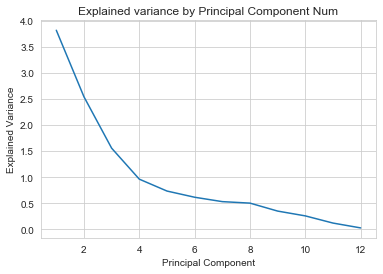

In [62]:
# Plot the explained variance for all principal components.
# Note: If the first value is too large, it may dwarf how the rest look.
# You may consider plotting starting with the 2nd value (python index at 1).
plt.plot([i + 1 for i in range(12)], pca.explained_variance_)
plt.title('Explained variance by Principal Component Num')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')

It appears that between 4-6 principal compoents are needed for a significant fit.

In [63]:
pca.explained_variance_

array([3.81814368, 2.54141373, 1.55547471, 0.96091476, 0.7328441 ,
       0.61396138, 0.52976977, 0.50117609, 0.34844287, 0.2562556 ,
       0.11848822, 0.02542457])

#### Linear regression with all 12 features

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     181.3
Date:                Thu, 04 Jun 2020   Prob (F-statistic):               0.00
Time:                        12:59:30   Log-Likelihood:                -5734.0
No. Observations:                5197   AIC:                         1.149e+04
Df Residuals:                    5184   BIC:                         1.158e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8184      0.010    574.384      0.0

Text(0.5, 1.0, 'Residual Histogram')

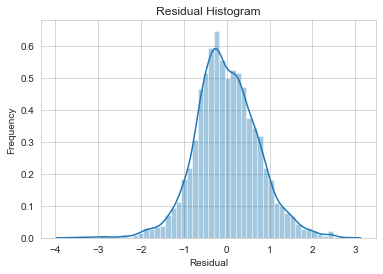

In [64]:
n = 12
formula_start = target + ' ~ '
formula_terms = ['pc' + str(x+1) for x in range(n)]
formula_end = ' + '.join(formula_terms)
formula_final = formula_start + formula_end

pcr_model = sm.ols(formula = formula_final, data=pca_df)

results = pcr_model.fit()

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

- The adjusted R-Squared is 0.291. Adjusted R-Squared shows how well the data points fits the regression line, taking into account the number of terms in the model.
- Using a threshold of 0.05, it appears that all but pc10 and pc11 have power greater than 0.05 so let's try the PCA regression with all but those inputs:

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     217.1
Date:                Thu, 04 Jun 2020   Prob (F-statistic):               0.00
Time:                        12:59:31   Log-Likelihood:                -5735.8
No. Observations:                5197   AIC:                         1.149e+04
Df Residuals:                    5186   BIC:                         1.157e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8184      0.010    574.299      0.0

Text(0.5, 1.0, 'Residual Histogram')

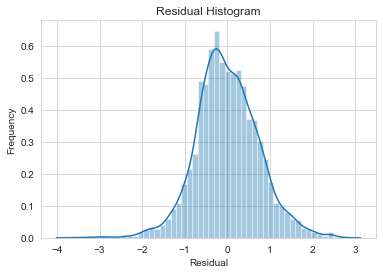

In [65]:
# perform linear regression with all but pc10 and pc11
formula_final = target + ' ~ pc1 + pc2 + pc3 + pc4 + pc5 + pc6 + pc7 + pc8 + pc9 + pc12'

pcr_model = sm.ols(formula = formula_final, data=pca_df)

results = pcr_model.fit()

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

With two features removed, the adjusted R-Squared is still 0.291. All model coefficients are now significant.

### Sklearn - Multivariant Linear Regression

In [66]:
# with sklearn
regression_model = LinearRegression()
# Fit the data(train the model)
x=pca_df[['pc1', 'pc2', 'pc3', 'pc4', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc12']]
y=pca_df['quality']

regression_model.fit(x, y)

# Predict
y_predicted = regression_model.predict(x)

print('Intercept: \n', regression_model.intercept_) # pull out intercept
print('Coefficients: \n', regression_model.coef_) # pull out coeffeicients

Intercept: 
 5.818356744275544
Coefficients: 
 [-0.06335062 -0.15800867  0.14109573  0.07129535  0.07129535 -0.1907004
  0.17241642  0.09474582  0.1195075  -0.31107729 -0.34814936]


In [67]:
# transform X_test as input into the model
column_names = ['pc' + str(ix+1) for ix in range(X_test.shape[1])]
X_test = pd.DataFrame(data = X_test, columns=column_names)
X_test = X_test[['pc1', 'pc2', 'pc3', 'pc4', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc12']]

In [68]:
# prediction with sklearn
y_pred = regression_model.predict(X_test)

In [69]:
# check difference between actual and predicted value
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison.head(10))

      Actual  Predicted
693        5   6.057532
2597       6   6.123161
4580       6   5.561590
393        5   6.821314
1539       5   5.995717
1321       6   5.338082
2350       5   5.159400
715        7   6.085997
169        5   5.310067
708        6   5.205105


Looks like we are in the general right direction with predicted fairly close to actual.

In [70]:
# model evaluation
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.85718752777389
Mean Squared Error: 1.183093781749693
Root Mean Squared Error: 1.0877011454207874


The root mean squared error is 1.39 which is slightly greater than 20% of the mean value of 5.82. This means that the model can make general good prediction, but is not very accurate.

## Summary:
- In this milestone, we prepared the data for modeling, used PCA to narrow down the features, and finally performed multivariant linear regression on the test data. The RMSE is 1.39 (~20% of the target mean), meaning that the model can make general good prediction, but is not very accurate.

# Naive Bayes Classification Model

In [71]:
# We learned from PCA that pc10 and pc11 are not significant so we'll drop them from the dataset
wine_nb = wine.drop(['pH', 'sulphates'], axis = 1)
# remember name of output/outcome/target column
label_col = 'quality'

In [72]:
wine_nb.dtypes

type                      int32
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
alcohol                 float64
quality                   int64
log_alcohol             float64
dtype: object

In [73]:
# Create label vector
wine_nb[label_col]=wine_nb[label_col].astype('category')
y = wine_nb[label_col].cat.codes

# Create 2D Feature array and labes
X = []
for c in wine_nb.columns:
    if c != label_col:
        if str(wine_nb[c].dtype) == 'category':
            X.append(wine_nb[c].cat.codes)
        else:
            X.append(wine_nb[c])
X = np.array(X).T
print('X:', X.shape, 'y:', y.shape)

X: (6497, 11) y: (6497,)


In [74]:
#split into training and testing data sets
X_nb_train, X_nb_test, y_nb_train, y_nb_test = train_test_split(X, y, test_size =0.20)
print('X_nb_test:', X_nb_test.shape, 'y_nb_test:', y_nb_test.shape)

X_nb_test: (1300, 11) y_nb_test: (1300,)


In [75]:
# Create the Model using training data
modelNB = n_b.MultinomialNB(alpha=3)

#Train the model using the training sets
modelNB.fit(X_nb_train, y_nb_train)

#Predict the response for test dataset
y_nb_pred = modelNB.predict(X_nb_test)
y_nb_pred_prob = modelNB.predict_proba(X_nb_test)

### Evaluate Model Performance

In [76]:
# take a look at the model results compared to the actual quality score
results = pd.DataFrame({
        'quality': y_nb_test,
        'predicted': y_nb_pred,
    })
results.head()

,quality,predicted
508,3,4
664,2,4
910,3,4
1381,2,1
2376,3,2


In [77]:
# model evaluation
print('Mean Absolute Error:', metrics.mean_absolute_error(y_nb_test, y_nb_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_nb_test, y_nb_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_nb_test, y_nb_pred)))
print('Accuracy:', metrics.accuracy_score(y_nb_test, y_nb_pred))

Mean Absolute Error: 0.8430769230769231
Mean Squared Error: 1.3476923076923077
Root Mean Squared Error: 1.1609015064562143
Accuracy: 0.3669230769230769


The root mean squared error is 1.02 which is better than the RMSE from the multivariant linear regression model. However the accuracy score is only 0.413. 

# LightGBM Model

In [78]:
params = {
          "objective" : "poisson",
          "metric" :"rmse",
          "force_row_wise" : True,
          "learning_rate" : 0.075,
          "sub_row" : 0.75,
          "bagging_freq" : 1,
          "lambda_l2" : 0.1,
          "metric": ["rmse"],
          'verbosity': 1,
          'num_iterations' : 1200,
          'num_leaves': 128,
          "min_data_in_leaf": 100,
         }

In [79]:
# use the same training/test set as the naive bayes model
train_set = lgb.Dataset(X_nb_train, y_nb_train)
val_set   = lgb.Dataset(X_nb_test, y_nb_test)

In [81]:
#train lgb model
lgb_model = lgb.train(params, train_set, num_boost_round=2500, early_stopping_rounds=50, valid_sets = [train_set, val_set], verbose_eval=100)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.635621	valid_1's rmse: 0.66743
[200]	training's rmse: 0.583865	valid_1's rmse: 0.652861
[300]	training's rmse: 0.546388	valid_1's rmse: 0.645827
[400]	training's rmse: 0.515364	valid_1's rmse: 0.641104
[500]	training's rmse: 0.489615	valid_1's rmse: 0.638773
Early stopping, best iteration is:
[538]	training's rmse: 0.480851	valid_1's rmse: 0.637547


In [84]:
train_pred = lgb_model.predict(X_nb_train)
train_score = np.sqrt(metrics.mean_squared_error(train_pred, y_nb_train))
val_pred = lgb_model.predict(X_nb_test)
val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_nb_test))

print(f'train rmse score is {train_score}')
print(f'test rmse score is {val_score}')

train rmse score is 0.48085080508825384
test rmse score is 0.6375470820095335


In [86]:
# take a look at the model results compared to the actual quality score
results = pd.DataFrame({
        'quality': y_nb_test,
        'predicted': val_pred,
    })
results.head()

,quality,predicted
508,3,2.285377
664,2,2.762988
910,3,3.317386
1381,2,1.597368
2376,3,3.261397


The root mean squared error is 0.637 which is better than the RMSE from the multivariant linear regression model and the Naive Bayes Classification Model.

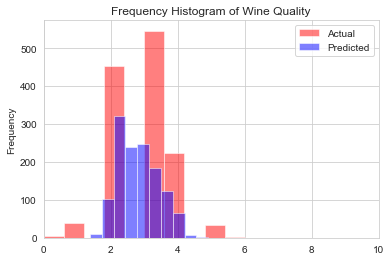

In [94]:
# plot predicted results against actual

actual=results['quality']
predicted=results['predicted']

figure = dict(alpha=0.5, bins=10)

plt.hist(actual, **figure, color='r', label='Actual')
plt.hist(predicted, **figure, color='b', label='Predicted')
plt.gca().set(title='Frequency Histogram of Wine Quality', ylabel='Frequency')
plt.xlim(0,10)
plt.legend()
plt.show()

The predicted quality follows the same general distribution as the actual. The predicted distribution is more normal.

# Model Summary
I built 3 models to predict quality of wine. The RSME score of each model is:
- Linear Regression:1.0877
- Naives Bayes: 1.1609
- LightGBM: 0.6375

**Since the LightGBM model gave us the lowest RMSE, this model should be used to make prediction of wine quality.**